In [1]:
# import data
from pylab import *
from sklearn.utils import shuffle
# from sklearn import preprocessing
import matplotlib.pyplot as plt
from scipy import stats
import sys
import pickle

sys.path.insert(0, '../src')

%matplotlib inline
import h5py

In [2]:
from numpy import *
import tensorflow as tf
import random as rn

import os
os.environ['PYTHONHASHSEED'] = '0'

np.random.seed(42)

rn.seed(12345)

# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
# tf.set_random_seed(12345)
tf.random.set_seed(12345)

sees = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# K.set_session(sees)
tf.compat.v1.keras.backend.set_session(sees)

Using TensorFlow backend.


In [3]:
# cnn model
import keras
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Flatten, Dropout, Activation
from keras.layers.convolutional import Conv1D, ZeroPadding1D, MaxPooling1D
from keras.utils import to_categorical
from keras.layers.core import Reshape 
from keras import activations

In [4]:
def build_model(trainX, trainy):
    keras.backend.clear_session()
    
    n_offset = trainX.shape[1]
    n_outputs = trainy.shape[1]
    print (n_outputs)
    n_features = 1
    
    model = Sequential()
#     model.add(Reshape((trainX.shape[1], 1), input_shape=(trainX.shape[1], )))
    
#     1st
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name='conv_1', input_shape=(n_offset,n_features)))
    model.add(MaxPooling1D(pool_size=2))  
#     model.add(Dropout(0.25))
              
#     2nd
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',name='conv_2'))
    model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))

#     3nd
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',name='conv_3'))
    model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))

#     4th
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same',name='conv_4'))
    model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.25))
              
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', name='dense'))
    
    model.add(Dense(n_outputs, activation='softmax', name='output'))   
    sgd = keras.optimizers.SGD(lr=0.01)
    model.compile(loss = "categorical_crossentropy", metrics=['accuracy'], optimizer = sgd)
    
#     model.compile(loss = "categorical_crossentropy", metrics=['accuracy'], optimizer = keras.optimizers.sgd())
           
    model.summary()
    return model

In [5]:
import pickle

def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['accuracy'])
    mse = smooth_curve(history.history['accuracy'][:steps])
    val_mse = smooth_curve(history.history['val_accuracy'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])
    
    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(mse, c='#0c7cba', label='Train accuracy')
    plt.plot(val_mse, c='#0f9d58', label='Val accuracy')
    plt.xticks(range(0, len(mse), 5))
    plt.xlim(0, len(mse))
    plt.title('Train accuracy: %.3f, Val accuracy: %.3f' % (mse[-1], val_mse[-1]), fontsize=12)
    plt.legend()

In [6]:
def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

In [7]:
def evaluate_model(X, y):
    verbose, epochs, batch_size = 1, 200, 64
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#     patience: Number of epochs with no improvement after which training will be stopped.
    model = build_model(X, y)
    history = model.fit(X, y, validation_split=0.2,
                    epochs=epochs, batch_size=batch_size, verbose=verbose,
                       callbacks=[early_stop]) 

    model.save_weights('model_weights_2+1uT_20210201_64_4.h5')
        
    save_history(history, 'history_2+1uT_20210201_64_4.bin')
#     history = load_history('history.bin')
#     plot_compare(history, steps=50)  
    return model

In [8]:
# summarize scores
def summarize_results(scores):
    # summarize mean and standard deviation
    for i in range(len(scores)):
        m, s = mean(scores[i]), std(scores[i])
        print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
        # boxplot of scores
    pyplot.boxplot(scores, labels=params)
    pyplot.savefig('exp_cnn_filters.png')

# load training data

In [9]:
cestFreq = np.linspace(-6,6,81)
filepath = '/Users/cbie1/OneDrive - Johns Hopkins/JHU/CEST/Machine_Learning_BreastTumor/double_tumor/material_paper/20210104/simulation_matlab/'

file=h5py.File(filepath + 'training_simData_2.0uT_20210201.h5','r')
simulationMatrix2pt = file['simData'][:]
simulationMatrix2pt = simulationMatrix2pt
trainingDataIndex2pt = file['Index'][:]
trainingDataIndex2pt.shape

file=h5py.File(filepath + 'training_simData_1.0uT_20210201.h5','r')
simulationMatrix1pt = file['simData'][:]
simulationMatrix1pt = simulationMatrix1pt
trainingDataIndex1pt = file['Index'][:]
trainingDataIndex1pt.shape

file=h5py.File(filepath + 'training_simData_0.5uT_20210201.h5','r')
simulationMatrix0pt5 = file['simData'][:]
simulationMatrix0pt5 = simulationMatrix0pt5
trainingDataIndex0pt5 = file['Index'][:]
trainingDataIndex0pt5.shape

(300000,)

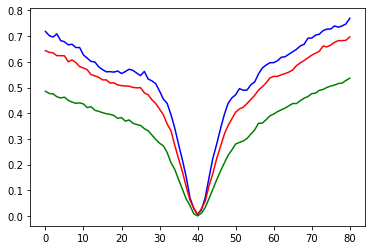

In [10]:
plot(simulationMatrix2pt[20],'b')
plot(simulationMatrix2pt[100000],'r')
plot(simulationMatrix2pt[200000],'g')

# model0 MCF-7 & MDA-231 & normal PCA

In [11]:
trainingDataIndex0 = trainingDataIndex2pt

In [11]:
freq_Zspec0 = np.where( (cestFreq >=-6.1) * (cestFreq <= 6.1))

trainingMatrix0 = []
for ii in range(simulationMatrix2pt.shape[0]):
    trainingFeatures = []
    trainingFeatures += list(squeeze(simulationMatrix2pt[ii,freq_Zspec0]))
    trainingFeatures += list(squeeze(simulationMatrix1pt[ii,freq_Zspec0]))
#     trainingFeatures += list(squeeze(simulationMatrix0pt5[ii,freq_Zspec0]))
    trainingMatrix0.append(trainingFeatures)
trainingDataNew0 = array(trainingMatrix0)

In [12]:
trainingDataIndex0 = keras.utils.to_categorical(trainingDataIndex2pt, 3)
# trainingDataIndex = reshape(trainingDataIndex2pt, (len(trainingDataIndex2pt),1))

In [13]:
trainX0 = trainingDataNew0
trainX0 = reshape(trainX0,(trainX0.shape[0], trainX0.shape[1], 1))
trainy0 = trainingDataIndex0

In [14]:
   # test data
testX, testy = shuffle(trainX0, trainy0, random_state=42)

In [17]:
# # CNN training
# import time

# start_time = time.clock()
# trainXnew = testX
# trainynew = testy
# model = evaluate_model(trainXnew, trainynew)

# print (time.clock() - start_time, "seconds")

3

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 162, 64)           256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 81, 64)            0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 81, 64)            12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 40, 64)            0         
_________________________________________________________________
conv_3 (Conv1D)              (None, 40, 64)            12352     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 20, 64)            0         
_________________________________________________________________
conv_4 (Conv1D)              (None, 20, 64)        

Epoch 37/200
240000/240000 [==============================] - 166s 691us/step - loss: 2.3570e-05 - accuracy: 1.0000 - val_loss: 1.2396e-06 - val_accuracy: 1.0000
Epoch 38/200
240000/240000 [==============================] - 166s 691us/step - loss: 1.9396e-05 - accuracy: 1.0000 - val_loss: 1.2175e-06 - val_accuracy: 1.0000
Epoch 39/200
240000/240000 [==============================] - 167s 694us/step - loss: 1.9868e-05 - accuracy: 1.0000 - val_loss: 1.2729e-06 - val_accuracy: 1.0000
Epoch 40/200
240000/240000 [==============================] - 150s 624us/step - loss: 2.1303e-05 - accuracy: 1.0000 - val_loss: 1.1783e-06 - val_accuracy: 1.0000
Epoch 41/200
240000/240000 [==============================] - 144s 599us/step - loss: 2.1174e-05 - accuracy: 1.0000 - val_loss: 1.1470e-06 - val_accuracy: 1.0000
Epoch 42/200
240000/240000 [==============================] - 145s 603us/step - loss: 2.1706e-05 - accuracy: 1.0000 - val_loss: 1.0483e-06 - val_accuracy: 1.0000
Epoch 43/200
240000/240000 [

240000/240000 [==============================] - 121s 503us/step - loss: 5.8647e-06 - accuracy: 1.0000 - val_loss: 1.5846e-07 - val_accuracy: 1.0000
Epoch 138/200
240000/240000 [==============================] - 128s 533us/step - loss: 4.8015e-06 - accuracy: 1.0000 - val_loss: 1.6462e-07 - val_accuracy: 1.0000
Epoch 139/200
240000/240000 [==============================] - 137s 569us/step - loss: 4.7460e-06 - accuracy: 1.0000 - val_loss: 1.5167e-07 - val_accuracy: 1.0000
Epoch 140/200
240000/240000 [==============================] - 137s 571us/step - loss: 4.6973e-06 - accuracy: 1.0000 - val_loss: 1.5937e-07 - val_accuracy: 1.0000
Epoch 141/200
240000/240000 [==============================] - 120s 500us/step - loss: 4.6649e-06 - accuracy: 1.0000 - val_loss: 1.8177e-07 - val_accuracy: 1.0000
Epoch 142/200
240000/240000 [==============================] - 116s 481us/step - loss: 4.7540e-06 - accuracy: 1.0000 - val_loss: 1.4389e-07 - val_accuracy: 1.0000
Epoch 143/200
240000/240000 [=======

In [15]:
trainXnew = testX
trainynew = testy
model = build_model(trainXnew, trainynew)
model.load_weights("model_weights_2+1uT_20210201_64_4.h5")


3
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv1D)              (None, 162, 64)           256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 81, 64)            0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 81, 64)            12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 40, 64)            0         
_________________________________________________________________
conv_3 (Conv1D)              (None, 40, 64)            12352     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 20, 64)            0         
_________________________________________________________________
conv_4 (Conv1D)              (None, 20, 64)         

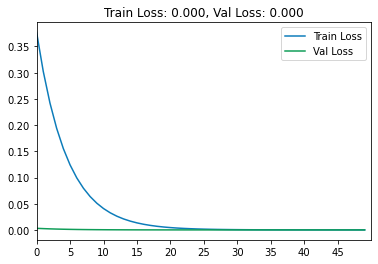

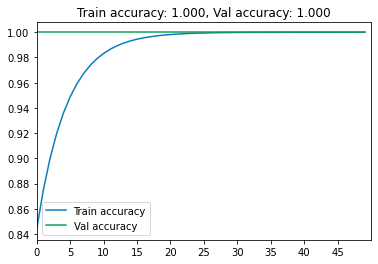

In [16]:
history = load_history('history_2+1uT_20210201_64_4.bin')
plot_compare(history, steps=50)

# test on in vivo data

In [57]:
# read data
import numpy

mouse = 'M3'
path2 = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/old_mice/M1-3/'
sep_2pt = np.loadtxt(path2 + 'M1_3whole_sep_2pt_denoising_filter.csv', delimiter = ',')
# whole_2pt = np.loadtxt(path2 + 'M1_3whole_test_2pt_denoising_filter.csv', delimiter = ',')
Index = np.loadtxt(path2 + 'M1_3whole_sep_2pt_denoising_filter_index.csv', delimiter = ',')

sep_1pt = np.loadtxt(path2 + 'M1_3whole_sep_1pt_denoising_filter.csv', delimiter = ',')
# whole_1pt = np.loadtxt(path2 + 'M1_3whole_test_1pt_denoising_filter.csv', delimiter = ',')

sep_0pt5 = np.loadtxt(path2 + 'M1_3whole_sep_0pt5_denoising_filter.csv', delimiter = ',')
# whole_0pt5 = np.loadtxt(path2 + 'M1_3whole_test_0pt5_denoising_filter.csv', delimiter = ',')


cestFreq = np.linspace(-6,6,81)

In [49]:
# read data
import numpy

mouse = 'M2'
path2 = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/old_mice/M2/'
sep_2pt = np.loadtxt(path2 + 'M2whole_sep_2pt_denoising_filter.csv', delimiter = ',')
# whole_2pt = np.loadtxt(path2 + 'M2whole_test_2pt_denoising_filter.csv', delimiter = ',')
Index = np.loadtxt(path2 + 'M2whole_sep_2pt_denoising_filter_index.csv', delimiter = ',')

sep_1pt = np.loadtxt(path2 + 'M2whole_sep_1pt_denoising_filter.csv', delimiter = ',')
# whole_1pt = np.loadtxt(path2 + 'M2whole_test_1pt_denoising_filter.csv', delimiter = ',')

sep_0pt5 = np.loadtxt(path2 + 'M2whole_sep_0pt5_denoising_filter.csv', delimiter = ',')
# whole_0pt5 = np.loadtxt(path2 + 'M2whole_test_0pt5_denoising_filter.csv', delimiter = ',')


cestFreq = np.linspace(-6,6,81)

In [87]:
# read data
import numpy

mouse = 'M4'
path2 = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/new_mice/M1-5/'
sep_2pt = np.loadtxt(path2 + 'M1whole_sep_2pt_denoising_filter.csv', delimiter = ',')
# whole_2pt = np.loadtxt(path2 + 'M1whole_test_2pt_denoising_filter.csv', delimiter = ',')
Index = np.loadtxt(path2 + 'M1whole_sep_2pt_denoising_filter_index.csv', delimiter = ',')

sep_1pt = np.loadtxt(path2 + 'M1whole_sep_1pt_denoising_filter.csv', delimiter = ',')
# whole_1pt = np.loadtxt(path2 + 'M1whole_test_1pt_denoising_filter.csv', delimiter = ',')

sep_0pt5 = np.loadtxt(path2 + 'M1whole_sep_0pt5_denoising_filter.csv', delimiter = ',')
# whole_0pt5 = np.loadtxt(path2 + 'M1whole_test_0pt5_denoising_filter.csv', delimiter = ',')


cestFreq = np.linspace(-6,6,81)

In [17]:
# read data
import numpy
#mouse3 -----------------------------
# # 2mm
mouse = 'M5'
path2 = '/Volumes/CX/JHU/Machine_Learning_BreastTumor/results/20210104/old_mice/M4/'
sep_2pt = np.loadtxt(path2 + 'M4whole_sep_2pt_denoising_filter.csv', delimiter = ',')
Index = np.loadtxt(path2 + 'M4whole_sep_2pt_denoising_filter_index.csv', delimiter = ',')

sep_1pt = np.loadtxt(path2 + 'M4whole_sep_1pt_denoising_filter.csv', delimiter = ',')
sep_0pt5 = np.loadtxt(path2 + 'M4whole_sep_0pt5_denoising_filter.csv', delimiter = ',')

cestFreq = np.linspace(-6,6,81)

In [18]:
expDataMatrix0_2pt_use = sep_2pt
expDataMatrix0_1pt_use = sep_1pt
expDataMatrix0_0pt5_use = sep_0pt5
# testLabel0 = Index
testLabel0 = keras.utils.to_categorical(Index, 3)

testLabel2 = Index
# testLabel2 = keras.utils.to_categorical(Index, 3)

In [19]:
# model0 data
combinedExpData0 = []
for ii in range(expDataMatrix0_2pt_use.shape[0]):
    combinedExpDatai = []
    combinedExpDatai+=list(squeeze(expDataMatrix0_2pt_use[ii,freq_Zspec0]))
    combinedExpDatai+=list(squeeze(expDataMatrix0_1pt_use[ii,freq_Zspec0]))
#     combinedExpDatai+=list(squeeze(expDataMatrix0_0pt5_use[ii,freq_Zspec0]))
#     combinedExpDatai+=list(lorezMatrixData0[ii,freq_Zspec0]*100)
    combinedExpData0.append(combinedExpDatai)
combinedExpData0 = array(combinedExpData0)

testInvivo0 = combinedExpData0

# testInvivo0 = data_test
testInvivo0 = reshape(testInvivo0, (testInvivo0.shape[0], testInvivo0.shape[1],1))

In [20]:
start_time = time.clock()
Invivo_pred0 = model.predict(testInvivo0)

Invivo_pred01 = zeros(Invivo_pred0.shape[0])

for ii in range(Invivo_pred0.shape[0]):
    Invivo_pred01[ii] = numpy.argmax(Invivo_pred0[ii])
    
    
print (time.clock() - start_time, "seconds")

3.7389720000000004 seconds


In [21]:
from sklearn import metrics
print('Step1: accuracy_score: %.3f' % (metrics.accuracy_score(testLabel2, Invivo_pred01)))


Step1: accuracy_score: 0.809


In [22]:
Invivo_pred = Invivo_pred01
testLabel = testLabel2

In [23]:
from imblearn.metrics import sensitivity_specificity_support
sensitivity_specificity_support(testLabel, Invivo_pred, average='macro')

/Users/cbie1/opt/anaconda2/envs/python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


(0.7900132153174749, 0.922227683761284, None)

In [24]:
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

results = confusion_matrix(testLabel, Invivo_pred)

print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(testLabel, Invivo_pred) )
print ('Report : ')
print (classification_report(testLabel, Invivo_pred))


Confusion Matrix :
[[ 91  13   0]
 [ 28  57   0]
 [  8  48 263]]
Accuracy Score : 0.8090551181102362
Report : 
              precision    recall  f1-score   support

         0.0       0.72      0.88      0.79       104
         1.0       0.48      0.67      0.56        85
         2.0       1.00      0.82      0.90       319

    accuracy                           0.81       508
   macro avg       0.73      0.79      0.75       508
weighted avg       0.86      0.81      0.82       508



In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Pastel1):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    matrix = zeros(cm.shape)
    for ii in range(matrix.shape[0]):
        for jj in range(matrix.shape[1]):
            if ii == jj:
                matrix[ii, jj] = 0.08
            else:
                matrix[ii, jj] = 0.1


    plt.imshow(matrix, cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=15)
    plt.yticks(tick_marks, classes, rotation=45, fontsize=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        tag = "{:.1f}%".format(round(cm[i, j]*100,1))
#         tag = "{:d}%".format(int(round(cm[i, j]*100)))
        if i == j:
            plt.text(j, i, tag, fontsize=13, color='k', horizontalalignment="center")
        else:
            plt.text(j, i, tag, fontsize=13, color='k', horizontalalignment="center")
#         plt.text(j, i, tag, fontsize=13,
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predictive label',fontsize=20)

Normalized confusion matrix
[[0.88 0.12 0.  ]
 [0.33 0.67 0.  ]
 [0.03 0.15 0.82]]


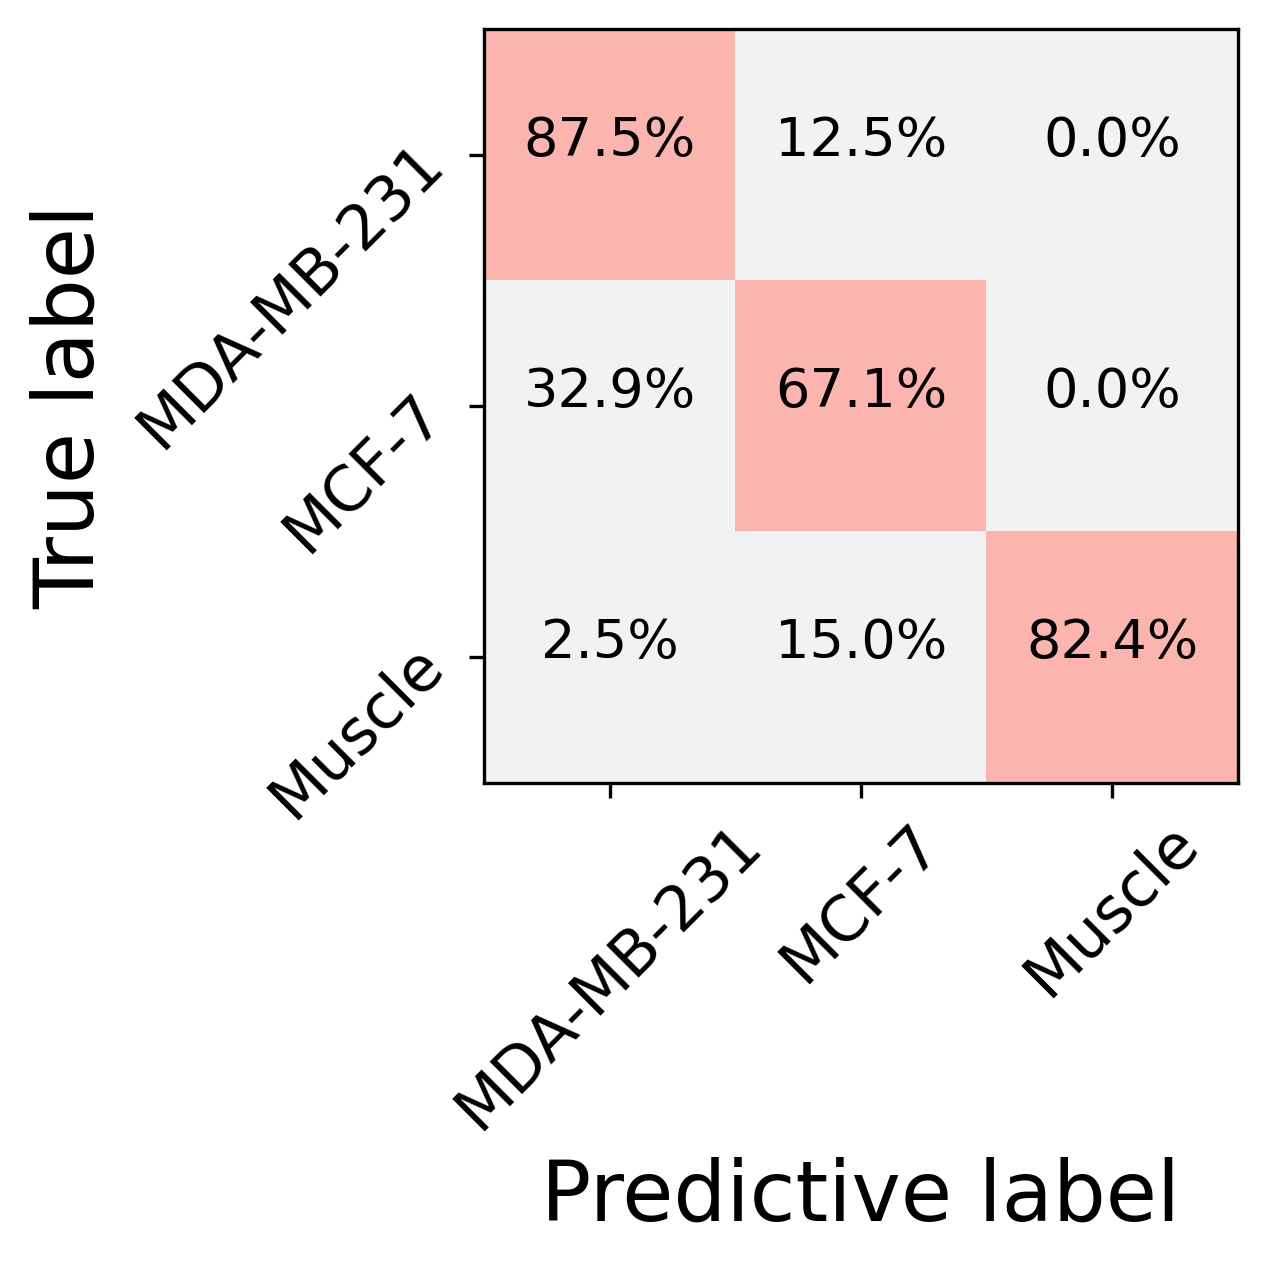

In [26]:
# Compute confusion matrix
import itertools
from sklearn.metrics import confusion_matrix

class_names = ['MDA-MB-231','MCF-7','Muscle']
cnf_matrix = confusion_matrix(testLabel, Invivo_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(dpi=300)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      normalize=True)
plt.show()

In [41]:
# save predicted results
numpy.savetxt(path2 + mouse+ '_pred_sep_knn_2+1uT_1.csv', Invivo_pred01, delimiter = ',')


In [42]:
y_score = model.predict_proba(testInvivo0)
# y_score = Invivo_pred0
y_test = testLabel0

y_score_new = zeros(y_score.shape)
for ii in range(y_score.shape[0]):
    for jj in range(y_score.shape[1]):
        y_score_new[ii,jj] = round(y_score[ii,jj],3)

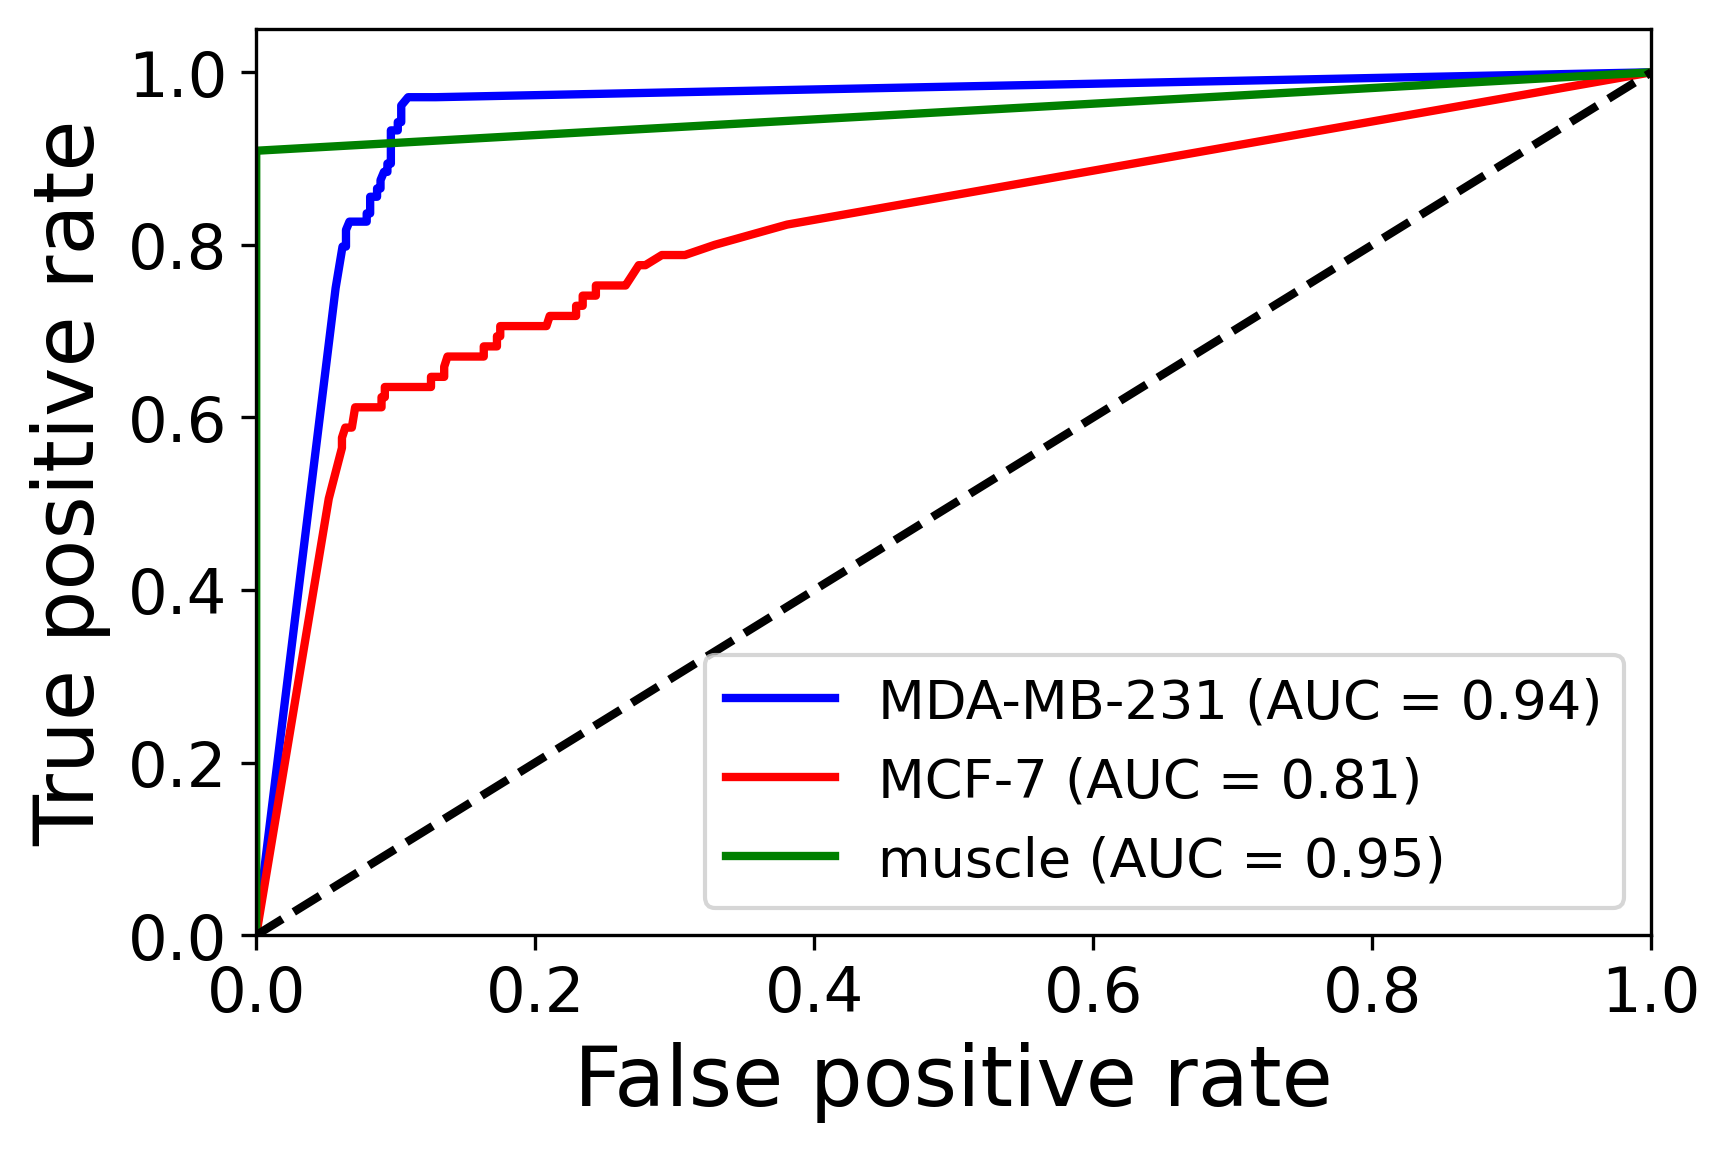

In [43]:
# y_score = model.predict_proba(testInvivo0)
# # y_score = Invivo_pred0
# y_test = testLabel0

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
n_classes = 3

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thresholds = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], y_score_new[:, i],pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])


# Plot all ROC curves
plt.figure(1, dpi=300)

colors = cycle(['b', 'r', 'g'])
class_label=['MDA-MB-231', 'MCF-7','muscle']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i],  color=color, lw=lw,
             label='{0} (AUC = {1:0.2f})'
             ''.format(class_label[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate',fontsize=20)
plt.ylabel('True positive rate',fontsize=20)
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right",fontsize=13)
plt.tick_params(labelsize=15)
plt.show()


 